In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os 
import ydata_profiling as yp
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('../data/full_gen_data.csv')
df.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,customer_id,...,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255,0
1,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255,0
2,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255,0
3,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238,0
4,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238,0


In [11]:
df.drop([ 'article', 'customer_id', 'article.1', 'style', 'sizes', 'cost', 'sales', 'regular_price', 'current_price',
         'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col'], axis=1, inplace=True)

In [12]:
df['retailweek'] = pd.to_datetime(df['retailweek'])
df['month'] = df['retailweek'].dt.month

df.drop(['retailweek'], axis=1, inplace=True)

In [13]:
df = df[['country', 'productgroup', 'category', 'gender', 'month',  'ratio', 'promo1', 'promo2', 'label']]
for col in df.columns:
    if col not in ['ratio', 'label']:
        df[col] = df[col].astype('category')

In [14]:
df.drop_duplicates(inplace=True)

In [15]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62156, 8), (15539, 8), (62156,), (15539,))

In [16]:
cat_cols = ['country', 'productgroup', 'category', 'gender', 'month', 'promo1', 'promo2']
num_cols = ['ratio']

preprocessor = ColumnTransformer([ ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols),
                                 ], remainder='passthrough')
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_train_prep.shape, X_test_prep.shape

((62156, 27), (15539, 27))

In [17]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_prep, y_train)

In [19]:
y_train.value_counts()

label
0    52039
1    10117
Name: count, dtype: int64

In [18]:
y_train_res.value_counts()

label
1    52039
0    52039
Name: count, dtype: int64

In [20]:
log_reg = LogisticRegression(random_state=42, max_iter=10000, solver='liblinear', class_weight='balanced')

lr_cv_results = cross_validate(log_reg, X_train_res, y_train_res, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(lr_cv_results['test_accuracy'].mean())
print(lr_cv_results['test_precision'].mean())
print(lr_cv_results['test_recall'].mean())
print(lr_cv_results['test_f1'].mean())
print(lr_cv_results['test_roc_auc'].mean())

0.76556049015678
0.7395380867535744
0.8198659135077813
0.7776262174355523
0.8327972221178325


In [21]:
log_reg_param_grid = {
    'C': [0.01, 0.1, 10],
    'penalty': ['l1', 'l2']
}

log_reg_grid_search = GridSearchCV(log_reg, log_reg_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
log_reg_grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 10], 'penalty': ['l1', 'l2']},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [22]:
log_reg_grid_search_results = pd.DataFrame(log_reg_grid_search.cv_results_)
log_reg_grid_search_results = log_reg_grid_search_results[['param_C', 'param_penalty', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
log_reg_grid_search_results.round(2)

,param_C,param_penalty,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,0.01,l1,0.77,0.74,0.82,0.78
1,0.01,l2,0.77,0.73,0.85,0.78
2,0.1,l1,0.77,0.74,0.82,0.78
3,0.1,l2,0.77,0.74,0.83,0.78
4,10,l1,0.77,0.74,0.82,0.78
5,10,l2,0.77,0.74,0.82,0.78


	 Log Reg classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     52039
           1       0.35      0.83      0.49     10117

    accuracy                           0.72     62156
   macro avg       0.65      0.76      0.65     62156
weighted avg       0.86      0.72      0.75     62156

############################################################
	 Log Reg confusion matrix on training set
############################################################


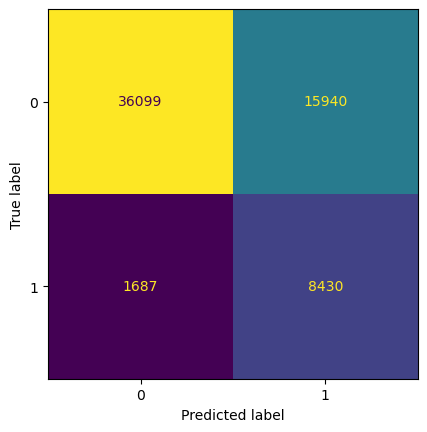

In [23]:
best_log_reg_params = {
    'C': 0.01,
    'penalty': 'l2'}

best_log_reg = LogisticRegression(**best_log_reg_params, random_state=42, max_iter=10000, solver='liblinear', class_weight='balanced')
best_log_reg.fit(X_train_res, y_train_res)

y_train_pred_lr = best_log_reg.predict(X_train_prep)

print("\t Log Reg classification report on training set")
print('#'*60)
print(classification_report(y_train, y_train_pred_lr))
print('#'*60)

print("\t Log Reg confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_lr, colorbar=False)

In [24]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_cv_results = cross_validate(rf, X_train_res, y_train_res, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(rf_cv_results['test_accuracy'].mean())
print(rf_cv_results['test_precision'].mean())
print(rf_cv_results['test_recall'].mean())
print(rf_cv_results['test_f1'].mean())
print(rf_cv_results['test_roc_auc'].mean())

0.7506006849440267
0.7460741620237604
0.7592386118637849
0.7523667888647207
0.8500419965537379


In [25]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt'],
    'max_depth': [10, 20, 30],
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
rf_grid_search.fit(X_train_res, y_train_res)


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 300]},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [26]:
rf_grid_search_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_grid_search_results = rf_grid_search_results[['param_n_estimators', 'param_max_depth', 'param_max_features',  'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
rf_grid_search_results.round(2)

,param_n_estimators,param_max_depth,param_max_features,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,100,10,None,0.79,0.73,0.93,0.82
1,200,10,None,0.79,0.73,0.93,0.82
2,300,10,None,0.79,0.73,0.93,0.82
3,100,10,sqrt,0.78,0.71,0.96,0.82
4,200,10,sqrt,0.78,0.71,0.97,0.82
5,300,10,sqrt,0.78,0.71,0.97,0.82
6,100,20,None,0.81,0.77,0.90,0.82
7,200,20,None,0.81,0.77,0.89,0.82
8,300,20,None,0.81,0.77,0.89,0.82
9,100,20,sqrt,0.79,0.74,0.91,0.81


	 RF classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     52039
           1       0.35      0.92      0.50     10117

    accuracy                           0.70     62156
   macro avg       0.66      0.79      0.65     62156
weighted avg       0.88      0.70      0.74     62156

############################################################
	 RF confusion matrix on training set
############################################################


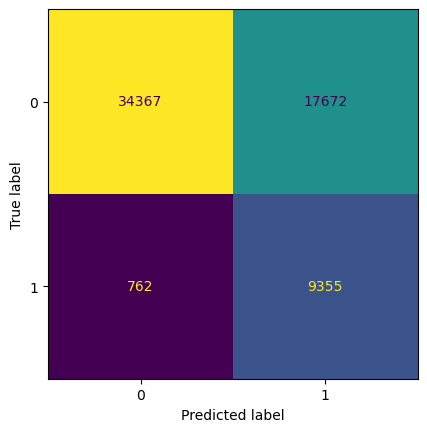

In [27]:
rf_grid_search_best_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': None
}

best_rf = RandomForestClassifier(**rf_grid_search_best_params, random_state=42, class_weight='balanced')
best_rf.fit(X_train_prep, y_train)

y_train_pred_rf = best_rf.predict(X_train_prep)

print("\t RF classification report on training set")
print('#'*60)
print(classification_report(y_train, y_train_pred_rf))
print('#'*60)

print("\t RF confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf, colorbar=False)

In [28]:
y_train_proba_lr = best_log_reg.predict_proba(X_train_prep)[:, 1]
y_train_proba_rf = best_rf.predict_proba(X_train_prep)[:, 1]

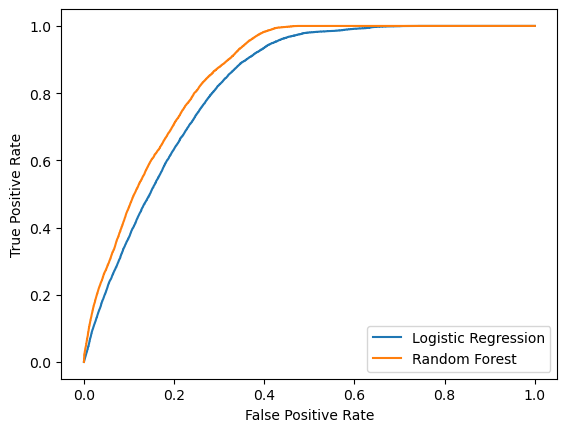

In [29]:
lr_fpr, lr_tpr, _ = roc_curve(y_train, y_train_proba_lr)
rf_fpr, rf_tpr, _ = roc_curve(y_train, y_train_proba_rf)

plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [31]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

# Compute ROC curve and thresholds
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_train, y_train_proba_lr)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_train, y_train_proba_rf)

# Create Plotly figure
fig = go.Figure()

# Add Logistic Regression ROC with thresholds in hover text
fig.add_trace(go.Scatter(
    x=lr_fpr,
    y=lr_tpr,
    mode='lines',
    name='Logistic Regression',
    text=[f"Threshold: {t:.2f}" for t in lr_thresholds],
    hoverinfo='text+x+y'
))

# Add Random Forest ROC with thresholds in hover text
fig.add_trace(go.Scatter(
    x=rf_fpr,
    y=rf_tpr,
    mode='lines',
    name='Random Forest',
    text=[f"Threshold: {t:.2f}" for t in rf_thresholds],
    hoverinfo='text+x+y'
))

# Update layout
fig.update_layout(
    title='ROC Curve with Thresholds (Hover)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template='plotly_white',
    width=800,
    height=500
)

fig.show()


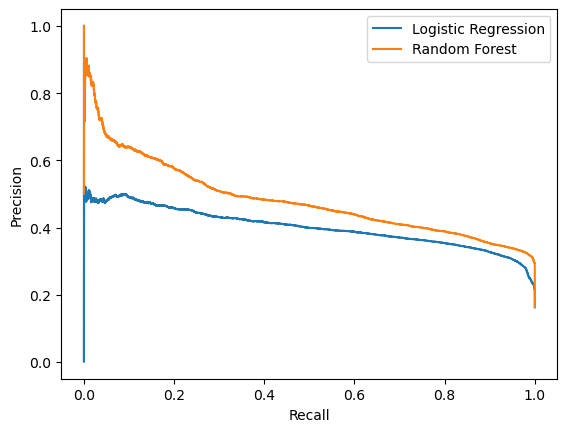

In [30]:
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_train, y_train_proba_lr)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_train, y_train_proba_rf)

plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

	 RF classification report on training set
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     52039
           1       0.40      0.75      0.52     10117

    accuracy                           0.78     62156
   macro avg       0.67      0.77      0.69     62156
weighted avg       0.85      0.78      0.80     62156



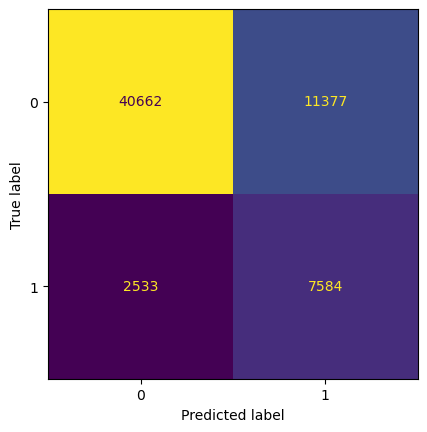

In [32]:
# For Rf: we will increase Probability threshold
prob_threshold = 0.65
rf_train_pred = best_rf.predict_proba(X_train_prep)[:, 1] > prob_threshold

print("\t RF classification report on training set")
print(classification_report(y_train, rf_train_pred))

ConfusionMatrixDisplay.from_predictions(y_train, rf_train_pred, colorbar=False)

In [34]:
from sklearn.pipeline import Pipeline

best_model = Pipeline([
    ('prep', preprocessor),
    ('rf', best_rf)
])


best_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['country', 'productgroup',
                                                   'category', 'gender',
                                                   'month', 'promo1',
                                                   'promo2'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features=None, random_state=42))])

	 RF classification report on test set
############################################################
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     13010
           1       0.37      0.68      0.48      2529

    accuracy                           0.76     15539
   macro avg       0.65      0.73      0.66     15539
weighted avg       0.83      0.76      0.78     15539

############################################################
	 RF confusion matrix on test set
############################################################


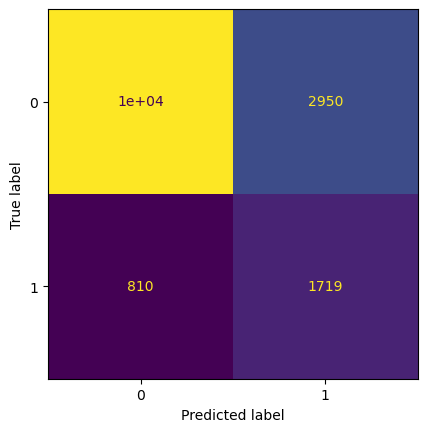

In [35]:
# Predict on test data
prob_threshold = 0.65
y_test_pred = best_model.predict_proba(X_test)[:, 1] > prob_threshold

print("\t RF classification report on test set")
print('#'*60)
print(classification_report(y_test, y_test_pred))
print('#'*60)

print("\t RF confusion matrix on test set")
print('#'*60)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, colorbar=False)

In [36]:
if not os.path.exists('../models'):
    os.makedirs('../models')

joblib.dump((best_model, prob_threshold), '../models/rf_model_less_features_smote_with_threshold.joblib')

['../models/rf_model_less_features_smote_with_threshold.joblib']

> Applying SMOTE has No significant effect on model performance